# Analisis exploratorio de los datos
- Primero importamos librerias y datos a ser usados
- Para juntar datos de varias columnas en una sola se ha usado la funcion get_values, obtenida del link: https://stackoverflow.com/questions/38334296/reversing-one-hot-encoding-in-pandas

In [1]:
#Importar librerias a usar
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pycountry
import plotly.express as px
import zepid
from zepid.graphics import EffectMeasurePlot

#Creación de data frames a usar
df_metadata = pd.read_csv("c:\\Users\\LENOVO\\Downloads\\Review_EDA_Emotion_Recognition\\Emmanuel\\data\\cleaned\\Tabla Normalizada - Metadata.csv")
df_data_type = pd.read_csv('c:\\Users\\LENOVO\\Downloads\\Review_EDA_Emotion_Recognition\\Emmanuel\\data\\cleaned\\Tabla Normalizada - Data type.csv')
df_participants = pd.read_csv('c:\\Users\\LENOVO\\Downloads\\Review_EDA_Emotion_Recognition\\Emmanuel\\data\\cleaned\\Tabla Normalizada - Participants.csv')
df_self_report = pd.read_csv('c:\\Users\\LENOVO\\Downloads\\Review_EDA_Emotion_Recognition\\Emmanuel\\data\\cleaned\\Tabla Normalizada - Self report.csv')
df_emotion_elicitation_techniques = pd.read_csv('c:\\Users\\LENOVO\\Downloads\\Review_EDA_Emotion_Recognition\\Emmanuel\\data\\cleaned\\Tabla Normalizada - Emotion elicitation techniques.csv')
df_eda = pd.read_csv('c:\\Users\\LENOVO\\Downloads\\Review_EDA_Emotion_Recognition\\Emmanuel\\data\\cleaned\\Tabla Normalizada - EDA.csv')
df_statistical_learning_models = pd.read_csv('c:\\Users\\LENOVO\\Downloads\\Review_EDA_Emotion_Recognition\\Emmanuel\\data\\cleaned\\Tabla Normalizada - Statistical Learning model.csv')
df_performances = pd.read_csv('c:\\Users\\LENOVO\\Downloads\\Review_EDA_Emotion_Recognition\\Emmanuel\\data\\cleaned\\Tabla Normalizada - Performances.csv')
df_alg_perf = pd.read_csv('c:\\Users\\LENOVO\\Downloads\\Review_EDA_Emotion_Recognition\\Emmanuel\\data\\cleaned\\Tabla Normalizada - Alg_Perf.csv')

# Set tamaño de gráficos para todos

In [2]:
plt.rcParams['figure.figsize'] = [20, 10]

## 1. Gráfico de barra por año (2010-2020) por paper según modelos de emociones empleado (categoriales o dimensionales)

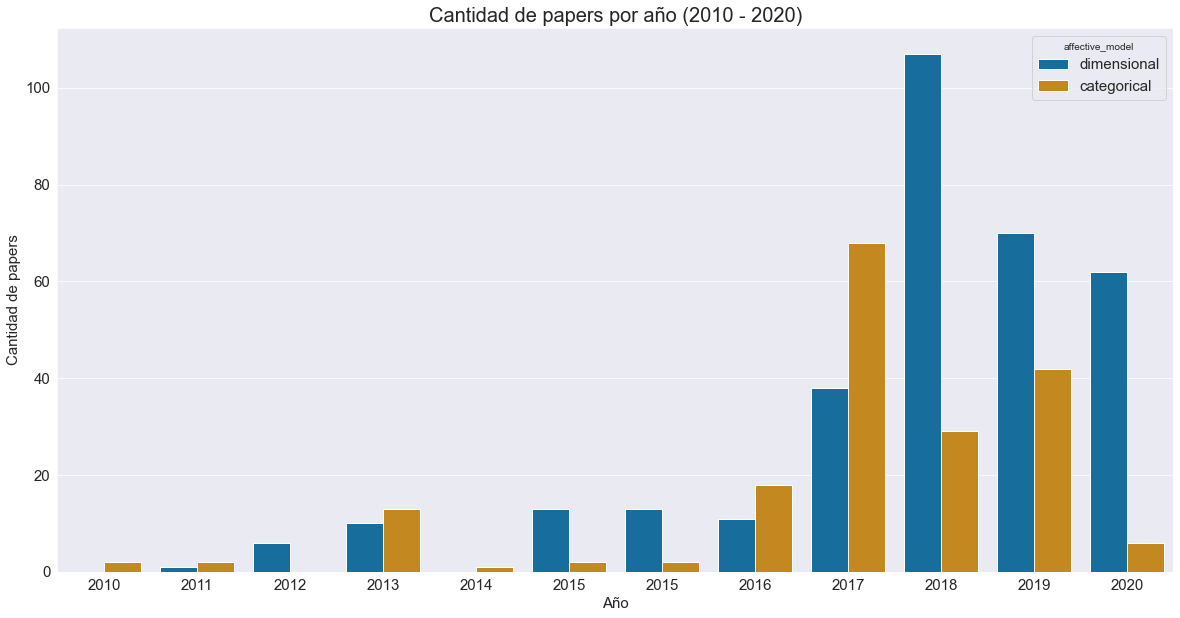

In [3]:
#rellenar datos faltantes y NO SE DROPEAN los duplicados (hay papers que usan multiples modelos)
df_statistical_learning_models=df_statistical_learning_models.fillna('-')

#ploteo
sns.set_style("darkgrid")
sns.set_palette('colorblind')
plt.rcParams["legend.fontsize"] = 15
plt.rcParams["xtick.labelsize"] = 15
plt.rcParams["ytick.labelsize"] = 15
plt.rcParams["axes.labelsize"] = 15
plt.rcParams["axes.titlesize"] = 20

category_order = [2010, 2011, 2012, 2013, 2014, 2015, 2015, 2016, 2017, 2018, 2019, 2020]
g= sns.countplot(x='year', 
    data= df_statistical_learning_models, 
    hue='affective_model', 
    order=category_order)
g.set(title = 'Cantidad de papers por año (2010 - 2020)', xlabel = 'Año', ylabel = 'Cantidad de papers')
plt.show()



## 2. Análisis estadístico para determinar si modelos de detección de arousal performan mejor que los basados en valence (Algoritmos de clasificación)
- Procedimiento: subsetear para quedarnos con modelos dimensionales(columna affective model), quedarse solo con clasificación binarias (LA,HA/LV,HV), quedarse con la medida de performance que mas aparezca (hacer count). hacer el test estadístico correspondiente (t, wettney, etc), que depende del supuesto (si hay normalidad se aplica paramétrico, sino no-parametrico).
- Resultado: no existe diferencia estadisticamente significativa entre grupos, por lo que los algoritmos clasificadores basados en modelos dimensionales de clasificacion binaria (HA/LA, HV/LV) no performan mejor uno sobre otros (Segun t de student y u de mann-whitney).
- Tener en cuenta el tamaño de la muestra que cumple con todos los criterios mencionados en el Procedimiento: 10 modelos en total.

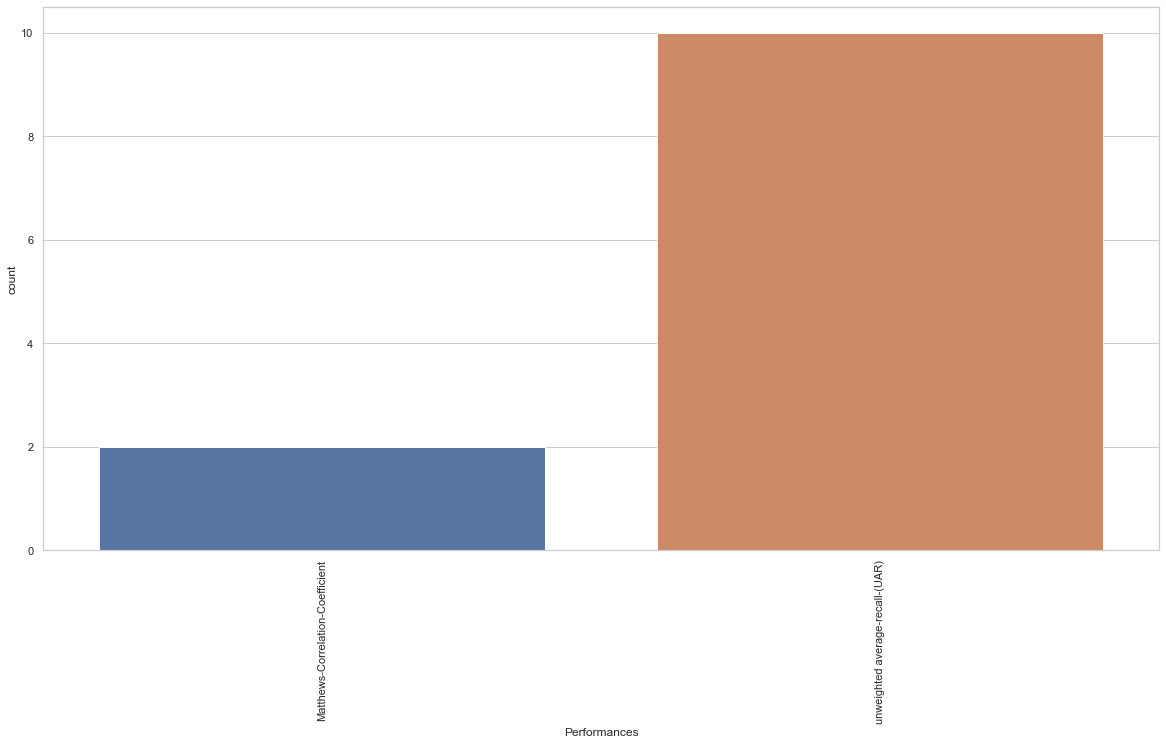

    paper_id model_id                                       apa_citation  \
482        -        -  Yang, H. C., & Lee, C. C. (2019, September). A...   
483        -        -  Yang, H. C., & Lee, C. C. (2019, September). A...   
484        -        -  Yang, H. C., & Lee, C. C. (2019, September). A...   
485        -        -  Yang, H. C., & Lee, C. C. (2019, September). A...   
486        -        -  Yang, H. C., & Lee, C. C. (2019, September). A...   
487        -        -  Yang, H. C., & Lee, C. C. (2019, September). A...   
488        -        -  Yang, H. C., & Lee, C. C. (2019, September). A...   
489        -        -  Yang, H. C., & Lee, C. C. (2019, September). A...   
490        -        -  Yang, H. C., & Lee, C. C. (2019, September). A...   
491        -        -  Yang, H. C., & Lee, C. C. (2019, September). A...   

     year affective_model is_classifier class_model_output_number  \
482  2020     dimensional             x                         2   
483  2020     dimensional

In [4]:
#creacion data frame y subseteo por: modelos dimensionales, tipo clasiffier, categorias HA/LA y HV/LV
df_2 = df_alg_perf
df_2 = df_2[df_2['affective_model'] == 'dimensional']
df_2 = df_2[df_2['is_classifier'].isin(['x', 'X'])]
df_2 = df_2[df_2['class_model_output_categories'].isin(['HA, LA', 'HV, LV'])]

#que medida de performance mas aparece en este grupo?
#dataframe con performances
df2_performance_medidas = df_2.iloc[:,67:]

#búsqueda de la medida de performance que mas aparece, paso de datos a 0 y 1 para facilitar su conteo
df2_performance_medidas = df2_performance_medidas.fillna('No')
df2_performance_medidas = df2_performance_medidas.replace('-', 'No')
df2_performance_medidas = df2_performance_medidas.mask(df2_performance_medidas != 'No','Yes')

def get_value(row):
    for c in df2_performance_medidas.columns:
        if row[c] == 'Yes':
            return c

df2_performance_medidas = df2_performance_medidas.apply(get_value, axis=1)
df2_performance_medidas = pd.DataFrame(df2_performance_medidas)
df2_performance_medidas.columns = ['Performances']

#ploteo para determinar la medida de performance mas recurrente
sns.set_theme(style="whitegrid", context = 'notebook')
sns.countplot(x='Performances', data=df2_performance_medidas)
plt.xticks(rotation=90)
plt.show()

#subseteo por la medida de performance que mas aparece (UAR)
df_2 = df_2.fillna('-')
df_2 = df_2[df_2['unweighted average-recall-(UAR)'] != '-']

print(df_2)
#la muestra es de 10 modelos


Aplicamos los estadísticos

obtenido de: https://machinelearningmastery.com/statistical-hypothesis-tests-in-python-cheat-sheet/

In [5]:
df_arousal = df_2[df_2['class_model_output_categories'] == 'HA, LA']
df_arousal = df_arousal['unweighted average-recall-(UAR)']
arousal = df_arousal.values.tolist()
arousal = list(map(float, arousal))

df_valence = df_2[df_2['class_model_output_categories'] == 'HV, LV']
df_valence = df_valence['unweighted average-recall-(UAR)']
valence = df_valence.values.tolist()
valence = list(map(float, valence))

#Test parametrico - t de student
print('Students t-test')
from scipy.stats import ttest_ind
stat, p = ttest_ind(arousal, valence, alternative = 'greater')
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
	print('Probably the same distribution')
else:
	print('Probably different distributions')


#Test no parametrico - U de Mann-Whitney
print('Mann-Whitney U Test')
from scipy.stats import mannwhitneyu
stat, p = mannwhitneyu(arousal, valence, alternative = 'greater')
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
	print('Probably the same distribution')
else:
	print('Probably different distributions')

Students t-test
stat=2.213, p=0.029
Probably different distributions
Mann-Whitney U Test
stat=22.000, p=0.028
Probably different distributions


## 3. Gráficos frencuencia de los modelos algoritimicos, según modelos de regresión y clasificación

- Interpretaciones: Los algoritmos clasificadores son por mucho los mas usados, ademas de ser los que mas variedad representan. Que implica esto? Es lo mismo aplicar algoritmos clasificadores o regresores?
- Nota: ordenar los valores de los gráficos y unirlos en uno, buscar graficar los mas usados (primeros 5 o 10) 

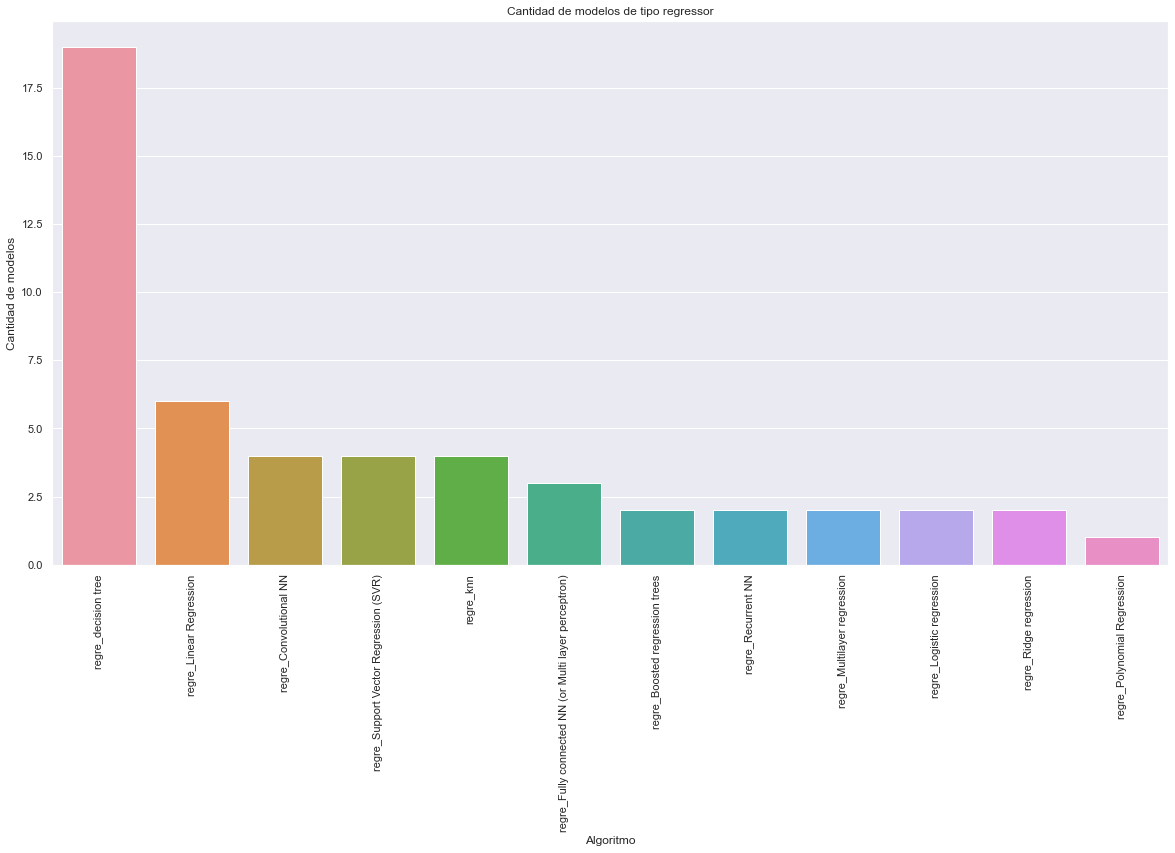

['class_Tree based models' 'class_Support Vector Machine (SVM)' None
 'class_k-Nearest Neighbor (k-NN)' 'class_Naive Bayes'
 'class_Cellular Neural Networks' 'class_AdaBoost DT'
 'class_Linear Discriminant Analysis (LDA)'
 'class_Quadratic discrimant clasifier (QDA)'
 'class_Quantum Neural Network (QNN)'
 'class_Probabilistic Neural Network (PNN)'
 'class_Extreme Learning Machine (ELM)' 'class_Backpropagation (BP)'
 'class_Convolutional NN' 'class_Gradient boostingclass'
 'class_Logistic Regression' 'class_HMM'
 'class_Fully connected NN (or Multi layer perceptron)' 'class_1R rule'
 'class_radial basis function\n(RBF) ' 'class_ANN' 'class_LSTM'
 'class_Spiking Deep Belief Network (SDBN)']


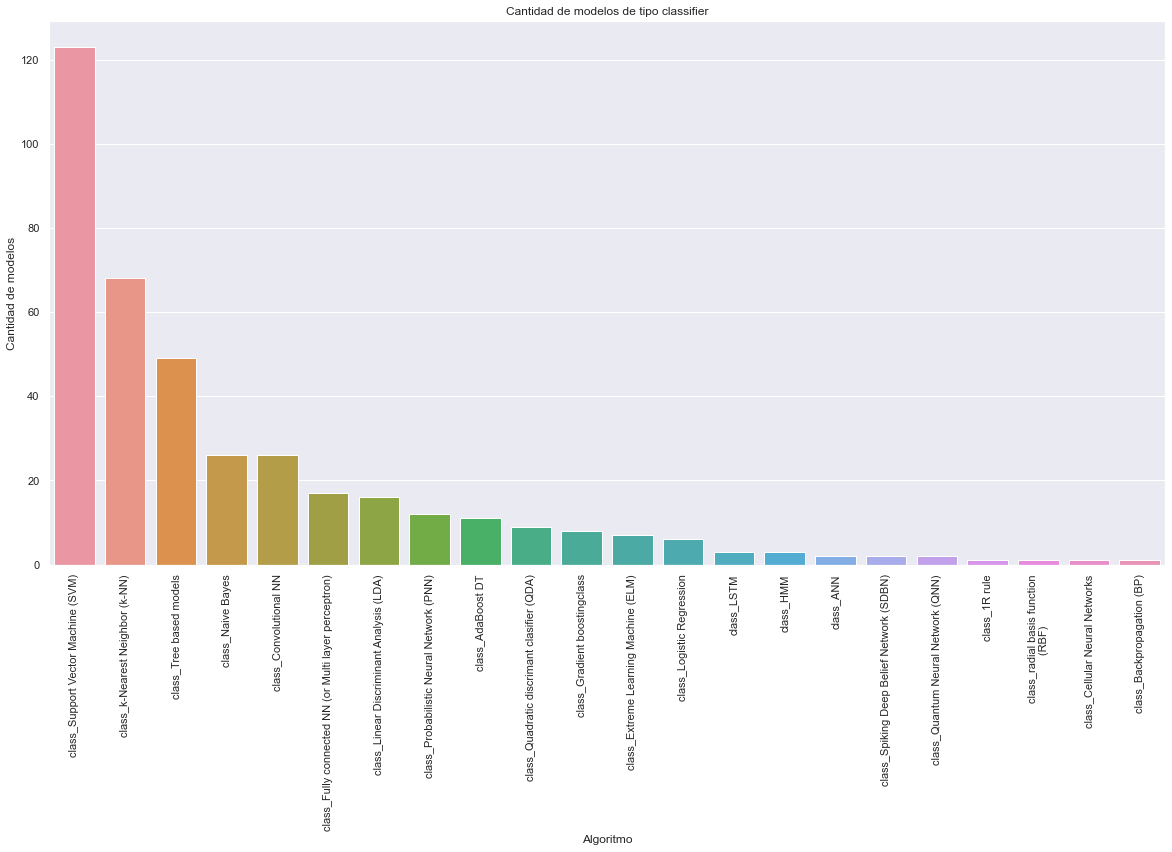

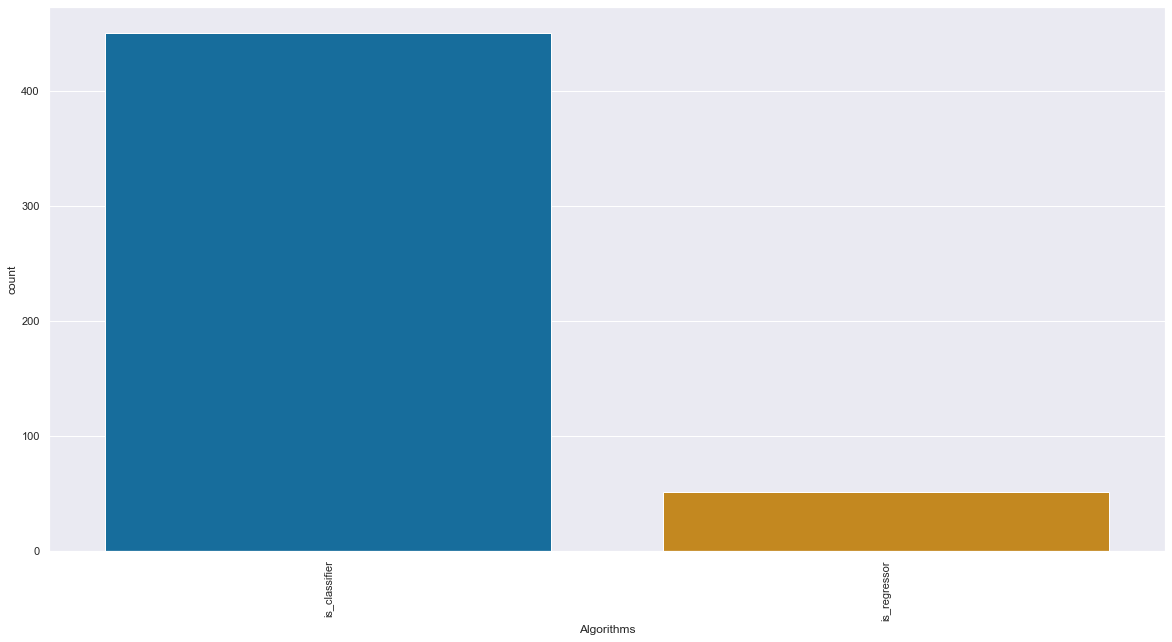

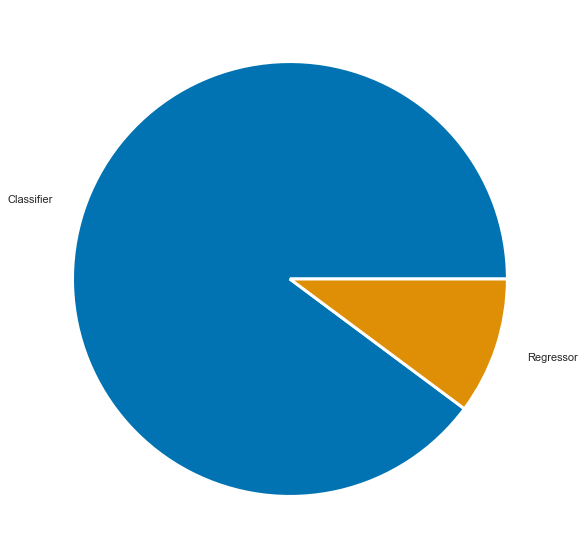

In [6]:
#para regressor
df_algoritmos_regre = df_statistical_learning_models.iloc[:,43:57]

def get_value(row):
     for c in df_algoritmos_regre.columns:
         if row[c]== 'x':
             return c

df_algoritmos_regre = df_algoritmos_regre.apply(get_value, axis=1)
df_algoritmos_regre = pd.DataFrame(df_algoritmos_regre)
df_algoritmos_regre.columns = ['Algorithms']

#Lista de algoritmos unicos de regresion
algoritmos_de_regresion = df_algoritmos_regre["Algorithms"].unique()
#print(algoritmos_de_regresion)

sns.set_style("darkgrid")
sns.set_palette('colorblind')
g = sns.countplot(x='Algorithms', data=df_algoritmos_regre, order=df_algoritmos_regre.Algorithms.value_counts().index)
g.set(title = 'Cantidad de modelos de tipo regressor', xlabel = 'Algoritmo', ylabel = 'Cantidad de modelos')
plt.xticks(rotation=90)
plt.show()

#para classifier
df_algoritmos_class = df_statistical_learning_models.iloc[:,8:40]
def get_value(row):
     for c in df_algoritmos_class.columns:
         if row[c]== 'x':
             return c

df_algoritmos_class = df_algoritmos_class.apply(get_value, axis=1)
df_algoritmos_class = pd.DataFrame(df_algoritmos_class)
df_algoritmos_class.columns = ['Algorithms']

#Lista de algoritmos unicos de clasificacion
algoritmos_de_clasificacion = df_algoritmos_class["Algorithms"].unique()
print(algoritmos_de_clasificacion)

sns.set_style("darkgrid")
sns.set_palette('colorblind')
g = sns.countplot(x='Algorithms', data=df_algoritmos_class, order=df_algoritmos_class.Algorithms.value_counts().index)
g.set(title = 'Cantidad de modelos de tipo classifier', xlabel = 'Algoritmo', ylabel = 'Cantidad de modelos')
plt.xticks(rotation=90)
plt.show()

#cantidad de modelos por tipo (regressor o clasiffier)
df_class_or_regre = df_statistical_learning_models.iloc[:,[5,40]]
def get_value(row):
     for c in df_class_or_regre.columns:
         if row[c]== 'x':
             return c

df_class_or_regre = df_class_or_regre.apply(get_value, axis=1)
df_class_or_regre = pd.DataFrame(df_class_or_regre)
df_class_or_regre.columns = ['Algorithms']

sns.set_style("darkgrid")
sns.set_palette('colorblind')
sns.countplot(x='Algorithms', data=df_class_or_regre)
plt.xticks(rotation=90)
plt.show()

#pie plot
quantity = df_class_or_regre['Algorithms'].value_counts()
df_class_or_regre_quantity = pd.DataFrame(quantity)

sns.set_style("darkgrid")
sns.set_palette('colorblind')
names = 'Classifier', 'Regressor'
plt.pie(df_class_or_regre_quantity['Algorithms'], labels = names, labeldistance = 1.15, wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' })
plt.show()


## 4. Gráfico frencuencia de los tipos de elicitation (por modalidad o tecnica especifica)

Nota: Falta organizar bien la data en la tabla, para obtener las siguientes barras: multimodal, modalidad visual, mod auditory, mod somatosensory

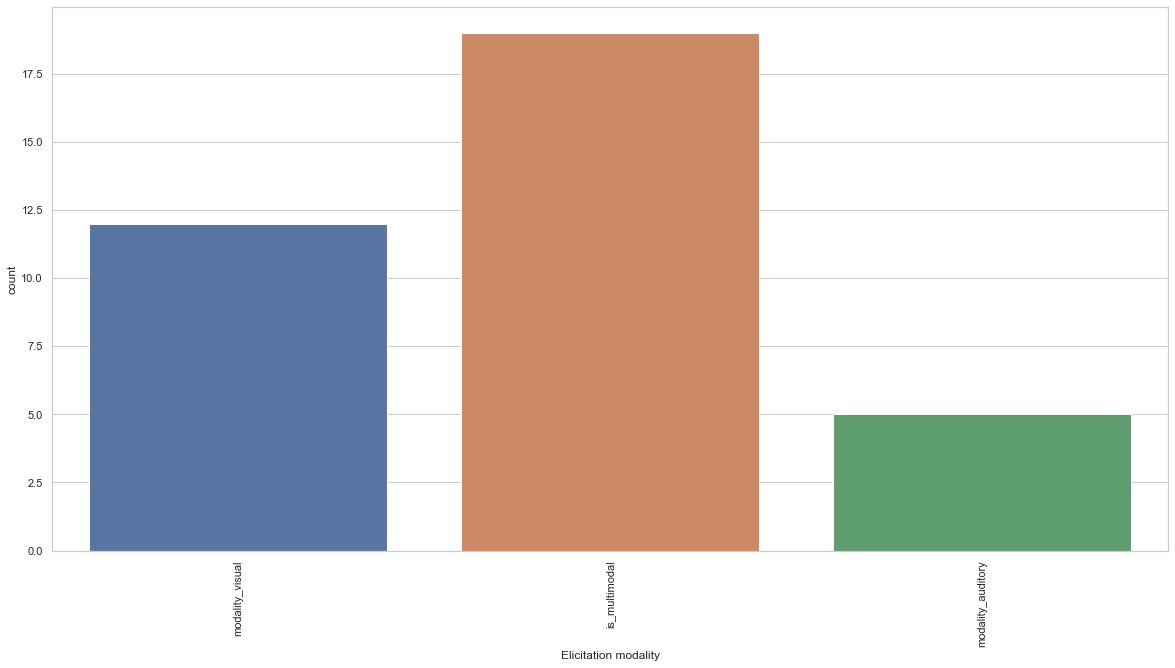

In [7]:
#frecuencia tipos elicitation por modalidad

df_emotion_elicitation_techniques=df_emotion_elicitation_techniques.fillna('-')
df_emotion_elicitation_techniques_sin_duplicates = df_emotion_elicitation_techniques.drop_duplicates(subset='paper_id')

df_eli_modalidad = df_emotion_elicitation_techniques_sin_duplicates.iloc[:,3:7]
def get_value(row):
     for c in df_eli_modalidad.columns:
         if row[c]== 'x':
             return c

df_eli_modalidad = df_eli_modalidad.apply(get_value, axis=1)
df_eli_modalidad = pd.DataFrame(df_eli_modalidad)
df_eli_modalidad.columns = ['Elicitation modality']

sns.set_theme(style="whitegrid", context = 'notebook')
sns.countplot(x='Elicitation modality', data=df_eli_modalidad)
plt.xticks(rotation=90)
plt.show()

## 5. Gráfico de barra por año (2010-2020) según tipos de base de datos (privada, pública)

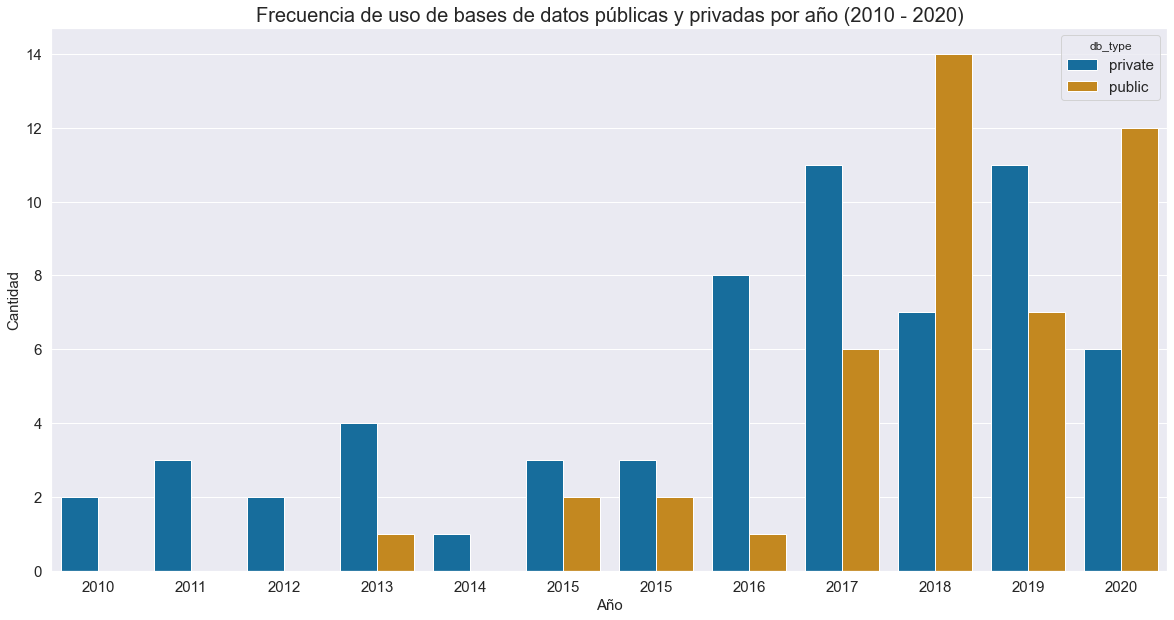

In [8]:
#rellenar datos faltantes y dropeo de duplicados
df_data_type=df_data_type.fillna('-')
df_data_type_sin_duplicates = df_data_type.drop_duplicates(subset='paper_id')

#ploteo
sns.set_style("darkgrid")
sns.set_palette('colorblind')
plt.rcParams["legend.fontsize"] = 15
plt.rcParams["xtick.labelsize"] = 15
plt.rcParams["ytick.labelsize"] = 15
plt.rcParams["axes.labelsize"] = 15
plt.rcParams["axes.titlesize"] = 20

category_order = [2010, 2011, 2012, 2013, 2014, 2015, 2015, 2016, 2017, 2018, 2019, 2020]
g = sns.countplot(x='year', 
    data= df_data_type_sin_duplicates, 
    hue='db_type', 
    order=category_order)
g.set(title = 'Frecuencia de uso de bases de datos públicas y privadas por año (2010 - 2020)', xlabel = 'Año', ylabel = 'Cantidad')
plt.show()

## 6. Gráfico frencuencia de uso de cada base de datos pública encontrada
- Interpretacion: Un predominio de pocas bases de datos. Estamos todo el tiempo sacando conclusiones sobre los mismos sujetos? Ver predominio de bases de datos publicas por sobre las privadas
- No se ha tenido en cuenta el dato aportado por Lorenzo (mas de una db por paper)

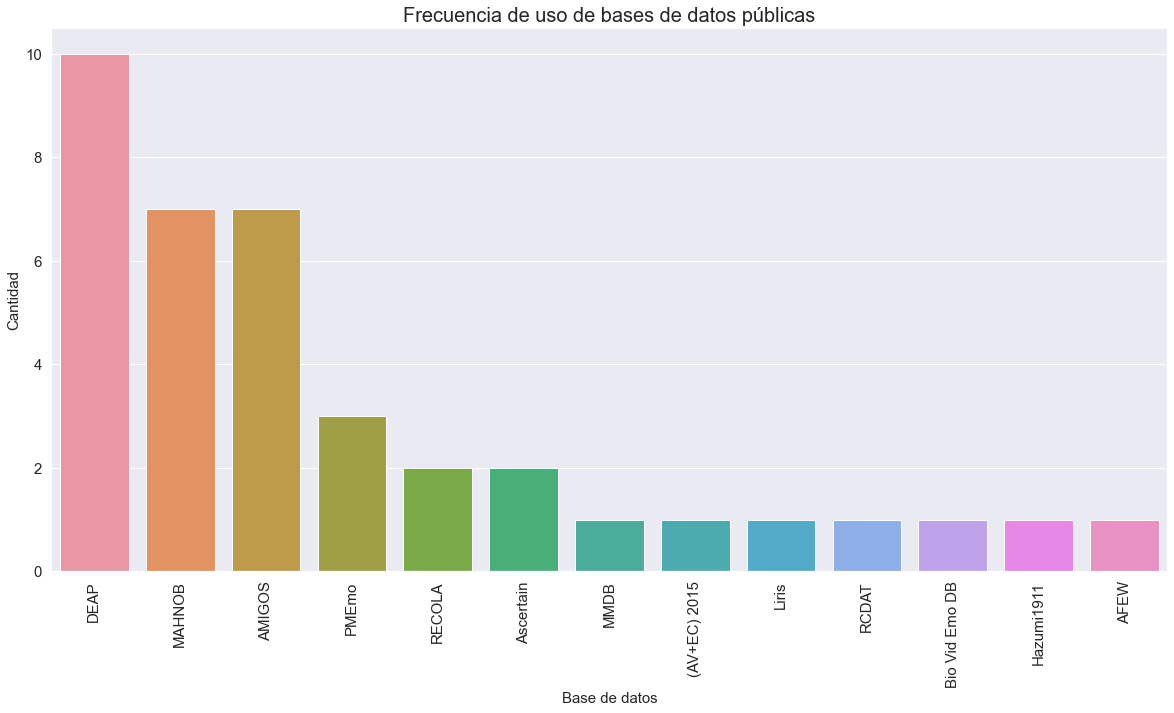

In [9]:
#bases de datos
df_data_type=df_data_type.fillna('-')
df_data_type_sin_duplicates = df_data_type.drop_duplicates(subset='paper_id')

df_db = df_data_type_sin_duplicates.iloc[:,11:]
def get_value(row):
     for c in df_db.columns:
         if row[c]== 'x':
             return c

df_db = df_db.apply(get_value, axis=1)
df_db = pd.DataFrame(df_db)

df_db = df_db.replace('Multimodal Dyadic Behavior (MMDB)', 'MMDB')
df_db.columns = ['Database']

#plot
sns.set_style("darkgrid")
sns.set_palette('colorblind')
plt.rcParams["legend.fontsize"] = 15
plt.rcParams["xtick.labelsize"] = 15
plt.rcParams["ytick.labelsize"] = 15
plt.rcParams["axes.labelsize"] = 15
plt.rcParams["axes.titlesize"] = 20

sns.set_style("darkgrid")
sns.set_palette('colorblind')
g = sns.countplot(x='Database', data=df_db, order = df_db.Database.value_counts().index)
g.set(title = 'Frecuencia de uso de bases de datos públicas', xlabel = 'Base de datos', ylabel = 'Cantidad')
plt.xticks(rotation=90)
plt.show()

## 7. Gráfico frecuencia de papers según revista científica de origen, distinguiendo entre las que poseen orientación en ingeniería de datos y las que no

Nota: falta filtrar bien cuales son journal, y cuales de estas son de ingenieria o no (diferenciarlas con color o hue)

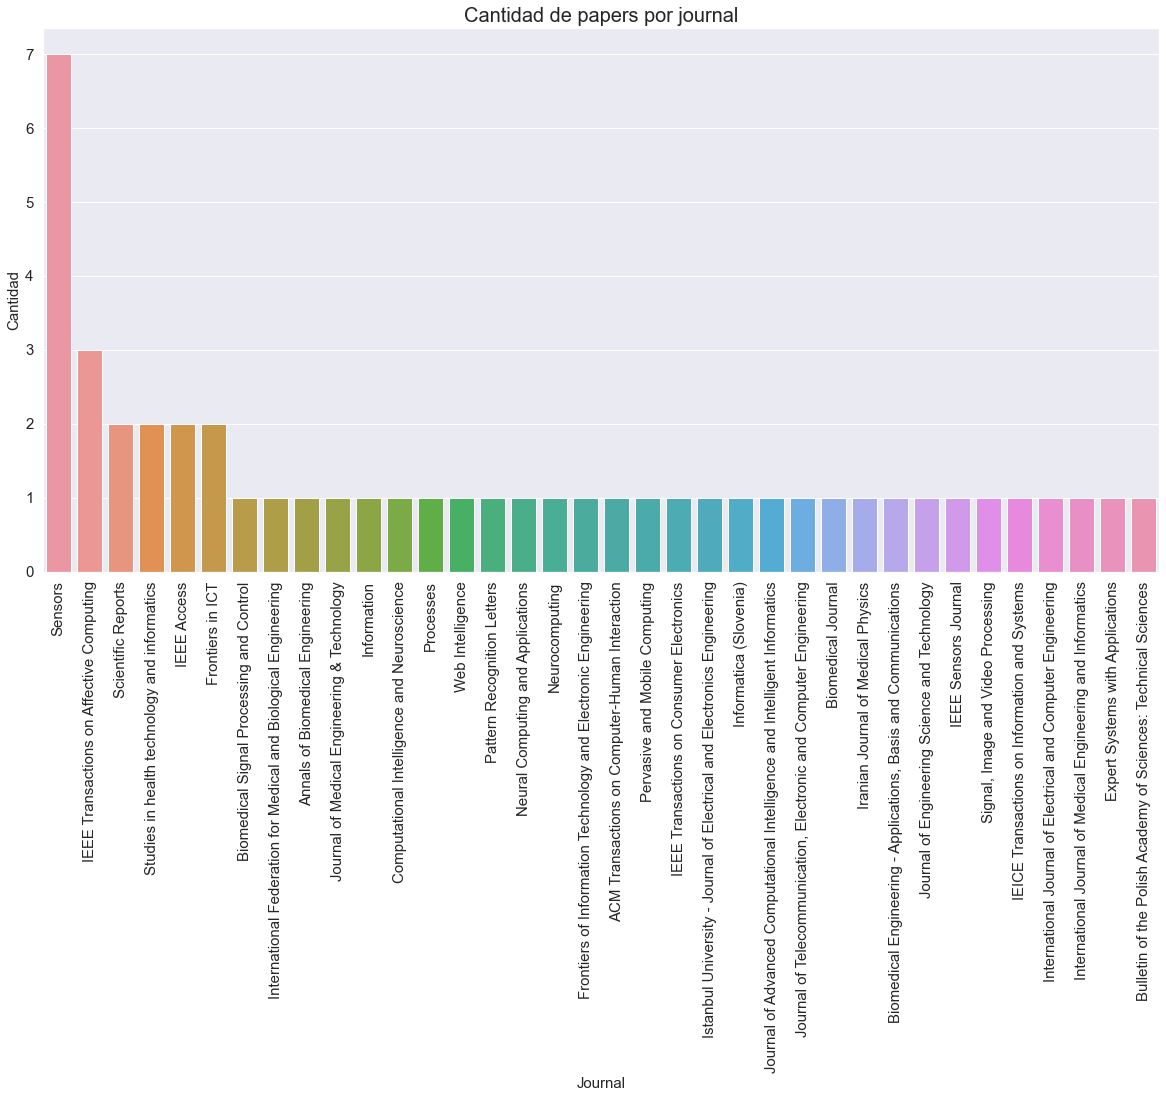

Sensors                                                                       7
IEEE Transactions on Affective Computing                                      3
Scientific Reports                                                            2
Studies in health technology and informatics                                  2
IEEE Access                                                                   2
Frontiers in ICT                                                              2
Biomedical Signal Processing and Control                                      1
International Federation for Medical and Biological Engineering               1
Annals of Biomedical Engineering                                              1
Journal of Medical Engineering & Technology                                   1
Information                                                                   1
Computational Intelligence and Neuroscience                                   1
Processes                               

In [10]:
#por revista
df_metadata=df_metadata.fillna('-')
df_metadata_sin_duplicates = df_metadata.drop_duplicates(subset='paper_id')

df_source_title = df_metadata_sin_duplicates[['paper_id','source_title','source_type_journal']]
df_source_title = df_source_title[df_source_title['source_type_journal'].isin(['x', 'X'])]

plt.rcParams["legend.fontsize"] = 15
plt.rcParams["xtick.labelsize"] = 15
plt.rcParams["ytick.labelsize"] = 15
plt.rcParams["axes.labelsize"] = 15
plt.rcParams["axes.titlesize"] = 20

sns.set_style("darkgrid")
sns.set_palette('colorblind')
g = sns.countplot(x='source_title', data=df_source_title, order = df_source_title.source_title.value_counts().index)
g.set(title = 'Cantidad de papers por journal', xlabel = 'Journal', ylabel = 'Cantidad')
plt.xticks(rotation=90)
plt.show()

lista_journals = df_source_title["source_title"].value_counts()
print(lista_journals)

# 8. Box plot comparando performance de modelos de arousal y de valencia 

- Es posible comparar la performance de modelos de arousal y de valencia (así como Roy et. al, 2019 comparan modelos de deep learning vs modelos baseline)?
Esto sería IDEAL, porque nos permitiría ver si efectivamente arousal tiene mejor performance que valencia.

- crear labs, lista de labels a usar en y (arousal models, valence models)
- crear measure, 
- crear lower, valor mas bajo de arousal y valence
- crear upper, valor mas alto de arousal y valence

               method  number  orbital_period   mass  distance  year
0     Radial Velocity       1      269.300000   7.10     77.40  2006
1     Radial Velocity       1      874.774000   2.21     56.95  2008
2     Radial Velocity       1      763.000000   2.60     19.84  2011
3     Radial Velocity       1      326.030000  19.40    110.62  2007
4     Radial Velocity       1      516.220000  10.50    119.47  2009
...               ...     ...             ...    ...       ...   ...
1030          Transit       1        3.941507    NaN    172.00  2006
1031          Transit       1        2.615864    NaN    148.00  2007
1032          Transit       1        3.191524    NaN    174.00  2007
1033          Transit       1        4.125083    NaN    293.00  2008
1034          Transit       1        4.187757    NaN    260.00  2008

[1035 rows x 6 columns]


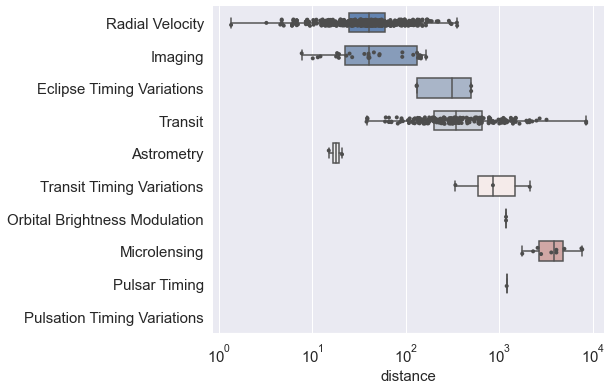

In [11]:


# Initialize the figure with a logarithmic x axis
f, ax = plt.subplots(figsize=(7, 6))
ax.set_xscale("log")

# Load the example planets dataset
planets = sns.load_dataset("planets")
print(planets)
# Plot the orbital period with horizontal boxes
sns.boxplot(x="distance", y="method", data=planets,
            whis=[0, 100], width=.6, palette="vlag")

# Add in points to show each observation
sns.stripplot(x="distance", y="method", data=planets,
              size=4, color=".3", linewidth=0)

# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set(ylabel="")
sns.despine(trim=True, left=True)

